# Итоговый проект (часть 2: модели)#
### Елизавета Клыкова, БКЛ181 ###
**Описание:** программа собирает тексты работ, опубликованных на международном ресурсе https://archiveofourown.org (все работы относятся к фандому "Mr. Robot (TV Show)"). Тексты обрабатываются морфологическими парсерами, данные сохраняются в базу SQLite. Для русского и английского языков создаются векторные, которые затем сравниваются по результатам разных тестов. Английской модели можно предложить текст какой-нибудь  работы, и она заменит в нем полнозначные слова на ближайшие синонимы (реализовано только на английских текстах, т.к. там меньше морфологии). Наконец, построены вордклауды наиболее частотных полнозначных слов русского и английского языков (чтобы выяснить, насколько похожи или различаются по содержанию работы на разных языках).

**Используемые инструменты:** краулеры, SQLite, морфологические парсеры, Word2vec, визуализации, dataframe.

Сначала включим проверку на PEP-8 и импортируем все необходимые для работы модули.

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
import collections
import gensim
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import random
import re
import seaborn as sns
import string
import sqlite3
import warnings
from bs4 import BeautifulSoup
from collections import OrderedDict
from gensim.models import KeyedVectors
from nltk import *
from nltk.corpus import stopwords
from pprint import pprint
from pymorphy2 import MorphAnalyzer
from string import punctuation
from tqdm.auto import tqdm
from wordcloud import WordCloud
%matplotlib inline
morph = MorphAnalyzer()
warnings.filterwarnings('ignore')

### Пункт 3. Лемматизация текстов (NLTK, pymorphy) ###
Добавим в таблицу fanfics колонку lem_texts.

In [3]:
db = sqlite3.connect('eaklykova_final.db')
cur = db.cursor()
cur.execute(
    '''ALTER TABLE fanfics ADD COLUMN lem_texts text''')
db.commit()

Для удобства работы преобразуем базу данных в pandas dataframe, затем построим датафрейм, отражающий, сколько работ на каждом языке содержится в нашем датафрейме.

In [4]:
df = pd.read_sql_query('SELECT * FROM fanfics', db)
lang_df = df.groupby(['language']).language.agg('count') \
            .to_frame('count').reset_index() \
            .sort_values(['count'], ascending=False)
lang_df

,language,count
0,English,868
6,Русский,25
1,Español,23
3,Italiano,9
7,中文,8
5,Português brasileiro,3
2,Français,2
4,Magyar,1


Возьмем только английские и русские работы - их больше всего.

In [5]:
cur.execute('''SELECT fanfic_id, full_text
FROM fanfics WHERE language = "English"''')
eng_texts = cur.fetchall()  # возвращает список tuple'ов
eng_text_list = [list(text) for text in eng_texts]  # список строк

cur.execute('''SELECT fanfic_id, full_text
FROM fanfics WHERE language = "Русский"''')
rus_texts = cur.fetchall()
rus_text_list = [list(text) for text in rus_texts]

Лемматизируем английские тексты с помощью NLTK, разделив предложения переносами строки (нужно для корректной работы векторной модели).

In [6]:
wnl = WordNetLemmatizer()
punct = string.punctuation  # стандартная пунктуация
other_punct = ['``', "\'\'", '...', '--', 'https', '–',
               '—', '«', '»', '“', '”', '’', '***', '…', '']
for text in tqdm(eng_text_list):
    no_dash_text = ' '.join(text[1].split('—'))
    sents = sent_tokenize(no_dash_text.lower())
    lemm_sents = []
    for sent in sents:
        tokens = [w.strip(punct).strip('…“”’-–—`*')
                  for w in word_tokenize(sent)
                  if w.strip(punct).strip('…“”’-–—`*')]
        tagged = nltk.pos_tag(tokens)
        lemmas = []
        for token in tagged:
            if token[1].startswith('V'):
                lemma = wnl.lemmatize(token[0], pos='v')
            else:
                lemma = wnl.lemmatize(token[0])
            # проверка на уровне лемм, т.к. иначе много ошибок
            if lemma not in punct and lemma not in other_punct:
                lemmas.append(lemma)
        if lemmas:
            lemm_sents.append(' '.join(lemmas))
    lem_text = '\n'.join(lemm_sents)
    text.append(lem_text)

Токенизируем русские тексты с помощью NLTK и лемматизируем их с помощью pymorphy, разделив предожения переносами строки.

In [7]:
for text in tqdm(rus_text_list):
    sents = sent_tokenize(text[1].lower())
    lemm_sents = []
    for sent in sents:
        tokens = word_tokenize(sent)
        lemmas = [morph.parse(t.strip('…'))[0].normal_form
                  for t in tokens
                  if t not in punct and t not in other_punct]
        if lemmas:
            lemm_sents.append(' '.join(lemmas))
    lem_text = '\n'.join(lemm_sents)
    text.append(lem_text)

Запишем обработанные тексты в соответствующие файлы.

In [8]:
def make_file_for_model(filename, texts):
    with open(filename, 'w', encoding='utf-8') as f:
        all_texts = []
        for text in texts:
            all_texts.append(text[-1])
        f.write(''.join(all_texts))

In [9]:
make_file_for_model('eng_model.txt', eng_text_list)
make_file_for_model('rus_model.txt', rus_text_list)

Запишем лемматизированные тексты в базу данных.

In [10]:
def lemm_texts_to_db(text_list):
    for text in text_list:
        cur.execute('''UPDATE fanfics SET lem_texts = ?
        WHERE fanfic_id = ?''', (text[-1], text[0],))
    db.commit()

In [11]:
lemm_texts_to_db(eng_text_list)
lemm_texts_to_db(rus_text_list)

In [12]:
db.close()

### Пункт 4. WordCloud лемм ###
Создадим список лемм, очищенных от стоп-слов, на основе созданных ранее файлов.

In [13]:
def get_lemmas(filename, language):
    if language == 'russian':
        stops = set(stopwords.words(language) + ['весь', 'это', '..'])
    elif language == 'english':
        stops = set(stopwords.words(language) + [".n't", "n't", "'s"])
    with open(filename, encoding='utf-8') as f:
        lemmas = f.read().split()
        no_stops = [lem for lem in lemmas if lem not in stops]
    return no_stops

In [14]:
eng_lemmas = get_lemmas('eng_model.txt', 'english')
rus_lemmas = get_lemmas('rus_model.txt', 'russian')

In [15]:
def create_wordcloud(lemmas, title):
    l_counter = collections.Counter(lemmas)
    wordCloud = WordCloud(background_color="white",
                          height=600, width=1000, max_words=100)
    wordCloud.generate_from_frequencies(l_counter)

    plt.figure(figsize=(15, 15), facecolor=None)
    plt.title(title, fontsize=20, pad=17)
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

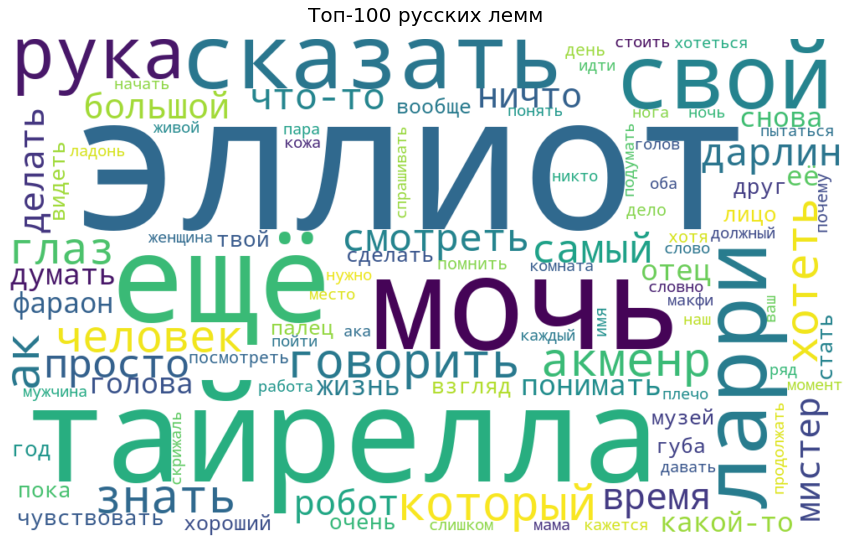

In [16]:
create_wordcloud(rus_lemmas, 'Топ-100 русских лемм')

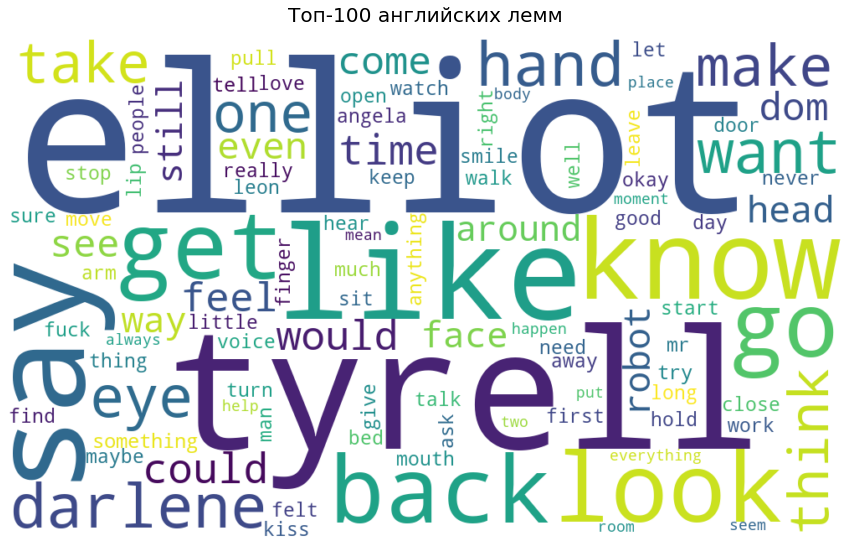

In [17]:
create_wordcloud(eng_lemmas, 'Топ-100 английских лемм')

Очевидно, что наиболее частотные леммы в работах на английском и русском совпадают: это имена главных героев (Эллиот, Тайрелл), некоторые глаголы (говорить, сказать, хотеть) и имена второстепенных персонажей (Дарлин, Мистер Робот и т.д.). Конечно, если бы русских работ было больше, список пересечений наверняка пополнился бы.

### Пункт 5. Word2Vec ###
Обучим английскую и русскую модели на соответствующих файлах, сохраним их в бинарном формате и выясним, сколько слов получилось в каждой модели.

In [18]:
def create_model(filename, model_path):
    f = filename
    data = gensim.models.word2vec.LineSentence(f)
    fm = gensim.models.Word2Vec(
        data, size=300, window=5, min_count=5, iter=50)
    fm.init_sims(replace=True)
    fm.wv.save_word2vec_format(model_path, binary=True)
    return len(fm.wv.vocab)

In [19]:
eng_len = create_model('eng_model.txt', 'eng_model.bin')
print('Кол-во слов в английской модели:', eng_len)

Кол-во слов в английской модели: 11342


In [20]:
rus_len = create_model('rus_model.txt', 'rus_model.bin')
print('Кол-во слов в русской модели:', rus_len)

Кол-во слов в русской модели: 1657


Загрузим модели для последующей работы с ними.

In [21]:
eng_m = KeyedVectors.load_word2vec_format('eng_model.bin', binary=True)
rus_m = KeyedVectors.load_word2vec_format('rus_model.bin', binary=True)

Сравним модели по нескольким тестам.

In [22]:
def most_sim_w(model, word):
    if word in model.wv:
        title = 'Соседи слова "' + word + '":\n'
        similar_w = model.wv.most_similar(positive=[word], topn=7)
        sim_ws = [w[0] + ' (' + str(w[1]) + ')'
                  for w in similar_w]
        result = title + '\n'.join(sim_ws)
    else:
        result = 'К сожалению, выбранного слова нет в модели.'
    return result

In [23]:
result = most_sim_w(eng_m, 'elliot')
print(result)

Соседи слова "elliot":
tyrell (0.7937356233596802)
he (0.7520555257797241)
leon (0.6383670568466187)
robot (0.5559099912643433)
him (0.5541512966156006)
irving (0.47755661606788635)
blaze (0.4665093421936035)


In [24]:
result = most_sim_w(rus_m, 'эллиот')
print(result)

Соседи слова "эллиот":
он (0.7281099557876587)
тайрелла (0.7055686116218567)
шейла (0.6241317391395569)
мужчина (0.5810321569442749)
боль (0.5765253305435181)
горло (0.5650395154953003)
дарлин (0.5601484775543213)


In [25]:
result = most_sim_w(eng_m, 'robot')
print(result)

Соседи слова "robot":
elliot (0.5559099912643433)
tyrell (0.5529675483703613)
perry (0.5231907963752747)
leon (0.5110501050949097)
jovonovich (0.5056238174438477)
barrot (0.4870297908782959)
he (0.4774375259876251)


In [26]:
result = most_sim_w(rus_m, 'робот')
print(result)

Соседи слова "робот":
норма (0.6695342659950256)
глупый (0.6450705528259277)
i (0.6145631670951843)
приходиться (0.6097466349601746)
дрожать (0.5666431188583374)
гай (0.5442283749580383)
зуб (0.5389333963394165)


In [27]:
def most_sim_ws(model, words):
    word1 = words[0]
    word2 = words[1]
    if word1 in model.wv and word2 in model.wv:
        title = 'Соседи слов "' + word1 + '" и "' + word2 + '":\n'
        similar_w = model.wv.most_similar(positive=words, topn=5)
        sim_ws = [w[0] + ' (' + str(w[1]) + ')' for w in similar_w]
        result = title + '\n'.join(sim_ws)
    else:
        result = 'Одного или обоих слов нет в модели.'
    return result

In [28]:
result = most_sim_ws(eng_m, ['start', 'end'])
print(result)

Соседи слов "start" и "end":
begin (0.47154802083969116)
speed (0.39863741397857666)
continue (0.32734882831573486)
wake (0.29056844115257263)
resume (0.2869288921356201)


In [29]:
result = most_sim_ws(rus_m, ['начало', 'конец'])
print(result)

Соседи слов "начало" и "конец":
когда-то (0.6717181205749512)
традиция (0.6271486282348633)
дело (0.6247795820236206)
рассвет (0.6193835735321045)
сей (0.6053721904754639)


In [30]:
result = most_sim_ws(eng_m, ['good', 'bad'])
print(result)

Соседи слов "good" и "bad":
great (0.5352451801300049)
terrible (0.5308564901351929)
amazing (0.4878973960876465)
real (0.44867995381355286)
stupid (0.44414809346199036)


In [31]:
result = most_sim_ws(rus_m, ['хороший', 'плохой'])
print(result)

Соседи слов "хороший" и "плохой":
факт (0.7684264183044434)
худой (0.7443269491195679)
чего-то (0.7266480922698975)
объяснять (0.7126061916351318)
попробовать (0.7089781761169434)


In [32]:
def semantic_proportion(model, word1, word2, word3):
    try:
        comment = word1 + ' + ' + word2 + ' - ' + word3 + ' = '
        res = model.wv.most_similar(
            positive=[word1, word2], negative=[word3], topn=1)[0][0]
        result = comment + res
    except KeyError:
        result = 'Одного или нескольких слов нет в модели.'
    return result

In [33]:
result = semantic_proportion(eng_m, 'man', 'son', 'woman')
print(result)

man + son - woman = father


In [34]:
result = semantic_proportion(rus_m, 'мужчина', 'сын', 'женщина')
print(result)

мужчина + сын - женщина = работа


Научим программу заменять все слова в английском тексте на ближайшие. Если слова нет в модели или оно является стоп-словом, замена не производится.

In [35]:
def change_text(model, text):
    stops = set(stopwords.words('english') + [".n't", "n't", "'s"])
    sents = text.split('\n')
    new_sents = []
    for sent in sents:
        lemmas = sent.split()
        new_lemmas = []
        for lemma in lemmas:
            if lemma not in model.wv or lemma in stops:
                new_lemmas.append(lemma)
            else:
                new_lemma = model.wv.most_similar(
                    positive=[lemma], topn=1)[0][0]
                new_lemmas.append(new_lemma)
        new_sent = ' '.join(new_lemmas).capitalize()
        new_sents.append(new_sent)
    new_text = '. '.join(new_sents)
    return new_text

Проверим работу программы на случайном лемматизированном тексте из базы данных.

In [36]:
def get_random_text():
    db = sqlite3.connect('eaklykova_final.db')
    cur = db.cursor()
    cur.execute('SELECT lem_texts FROM fanfics WHERE language = "English"')
    eng_texts = cur.fetchall()  # возвращает список tuple'ов
    lem_texts = [text[0] for text in eng_texts]  # список строк
    idx = random.randint(0, len(lem_texts))
    random_text = lem_texts[idx]
    db.close()
    return random_text

In [37]:
new_text = change_text(eng_m, get_random_text())
print(new_text)

The truck be must warmth give a messier sort of hunger. Tyrell wo n't distract shudder. Can hardly felt his hand and leg in a horrifying adjustment badly more respect the overdose of the elephant life he s no people to frostbite. This be anything weird the gasoline-induced flame he and sheesh elliot have begin in the backward of that darkness fsociety car a rushing sexual people too smart to sit next. So tyrell have stroll off maybe half-a-mile from the car to tell how much he could come before anyone wrong arrives the promotion. This be how dom have figure him through her laptop stagger backward. It be n't her truck or any truck he recognise but he be n't come to tell after what have do. He s glad in the adjustment he be n't swig. Perhaps they re both glad. For now he allow his hand prop against the chair uncomfortable. Dom maintain her finger tightly on the steering ferris an treat of inescapable heat that tell tyrell of their father. She have must pick the leader no tell. It s an an